/Users/aidanhsu/Documents/gaus-proc/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/aidanhsu/Documents/gaus-proc/.venv/lib/python3.12/site-packages/scipy/stats/_stats_py.py:7654: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs - f_exp)**2 / f_exp
/Users/aidanhsu/Documents/gaus-proc/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/aidanhsu/Documents/gaus-proc/.venv/lib/python3.12/site-packages/sklearn/gaussian_process

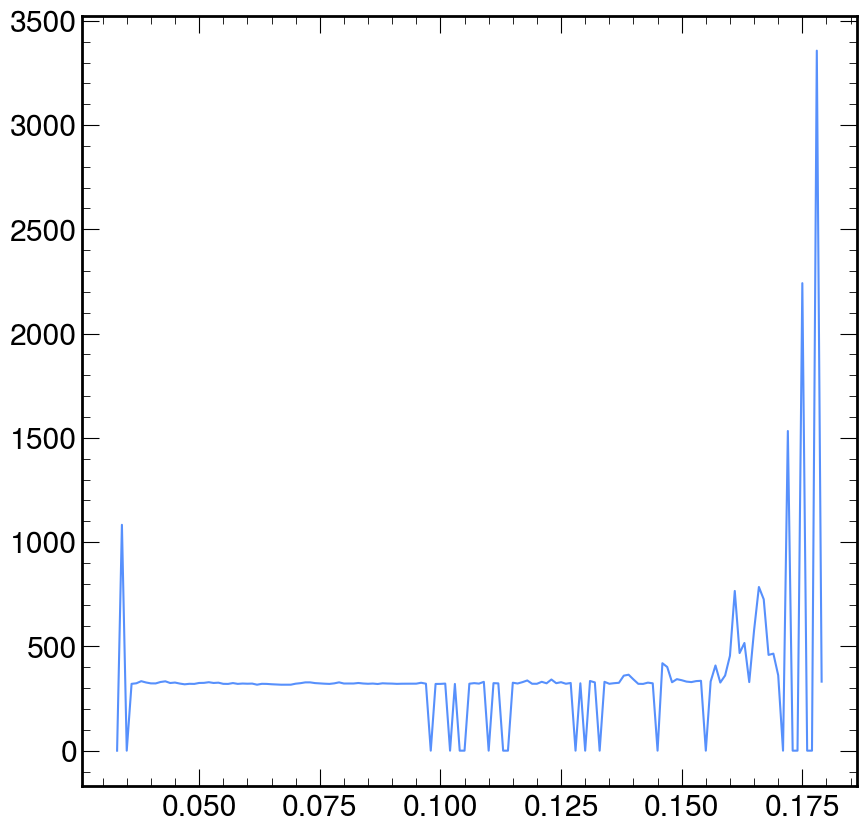

In [1]:
%load_ext autoreload
%autoreload 2
    
import gp
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame
import openpyxl
import math
# Making table for testing masses. Currently gives lots of inf values for unknown reason.
mass_hypothesis = .100
mass_hypotheses = np.linspace(.033,.179,147).tolist()
# Coefficients for the polynomial from the table for unsmeared (P0 to P4)
coefficients = [0.00032, 0.019, -0.11, 1.39, -4.33]


def sigma(mass, coeffs):
    #sigma is twice the mass resolution
    return 2 * sum(c * mass**i for i, c in enumerate(coeffs))

def sigmas(masses, coeffs):
    sigma_list = []
    for mass in masses:
        sigma_list.append(2 * sum(c * mass**i for i, c in enumerate(coeffs)))
    return sigma_list


def make_table(masses, coeffs):
    sigma_list = sigmas(masses, coeffs)
    chisquare_list = []
    p_value_list = []
    for i in range(len(masses)):
        
        m = gp.GaussianProcessModel(
            h = 'real', # use real IMD from ROOT file in this directory
            kernel = gp.kernels.Product(gp.kernels.RBF(), gp.kernels.DotProduct()),
            blind_range = (masses[i]-(sigma_list[i]), masses[i]+(sigma_list[i])),
            #modify_histogram = [gp._hist.manipulation.rebin_and_limit(10, 0.033, 0.179), gp._hist.manipulation.inject_signal(5000,sigma(mass_hypothesis, coefficients),mass_hypothesis)]
            modify_histogram = gp._hist.manipulation.rebin_and_limit(10, 0.033, 0.179)
        )
        m.model
        m.model.kernel_
        chisquare_list.append(m.chi2_statistic)
        p_value_list.append(m.p_value)
    return sigma_list, chisquare_list, p_value_list

sl, csl, pvl = make_table(mass_hypotheses, coefficients)
sl2, csl2, pvl2 = make_table(mass_hypotheses, coefficients)
sl3, csl3, pvl3 = make_table(mass_hypotheses, coefficients)
sl4, csl4, pvl4 = make_table(mass_hypotheses, coefficients)


#Scuffed thing I did to try to minimize amount of infs from chisquare.
new_pvl = []
new_csl = []
"""
for i in range(len(pvl)):
    if pvl[i] == 0 or pvl2[i] == 0:
        if pvl[i] == 0 and pvl2[i] != 0:
            new_pvl.append(pvl2[i])
        elif pvl[i] != 0 and pvl2[i] == 0:
            new_pvl.append(pvl[i])
        else:
            new_pvl.append(pvl[i])
    else:
        new_pvl.append(max(pvl[i], pvl2[i]))
        
    if math.isinf(csl[i]) or math.isinf(csl2[i]):
        if math.isinf(csl[i]) and not (math.isinf(csl2[i])):
            new_csl.append(csl2[i])
        elif not math.isinf(csl[i]) and math.isinf(csl2[i]):
            new_csl.append(csl[i])
        else:
            new_csl.append(csl[i])
    else:
        new_csl.append(min(csl[i], csl2[i]))
"""

for i in range(len(pvl)):
        new_pvl.append(max(pvl[i], pvl2[i], pvl3[i], pvl4[i]))
        new_csl.append(min(csl[i], csl2[i], csl3[i], csl4[i]))

# Put table in Excel file

df = DataFrame({'Mass': mass_hypotheses, 'Blind Range Size': [i*2 for i in sl], 'Chisquare': new_csl, 'Chisquare Probability': new_pvl})
df.to_excel('test1.xlsx', sheet_name='sheet1', index=False)

#Plot mass vs chisquare

plot_csl = []
for cs in csl:
    if math.isinf(cs) or abs(cs) > 5000:
        plot_csl.append(0)
    else:
        plot_csl.append(cs)

plt.plot(mass_hypotheses, plot_csl, label='Chisquare vs Mass')